In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
import napari
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

Index(['index', 'ID', 'VISIBILITY', 'QUALITY', 'RADIUS', 'POSITION_T',
       'POSITION_X', 'POSITION_Y', 'FRAME', 'POSITION_Z', 'graph_key',
       'linear_track_id', 'uv_v', 'uv_u', 'px_z', 'px_y', 'px_x',
       'uv_distance_from_edge', 'intensity_mean', 'uv_z', 'area_distortion',
       'uv_area', 'timepoint', 'px_area', 'mesh_name', 'id_prev', 'index.1',
       'interpolated', 'is_swapped', 'track_id', 'tracklet_id', 'parent_id',
       'n_children', 'n_parents', 'tracklet_first_parent_id',
       'tracklet_parent_tracklet'],
      dtype='object')


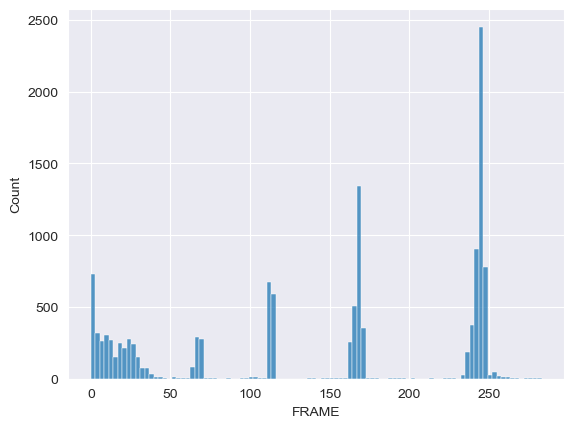

In [4]:
source = r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_04_14\hybrid3\spots.csv"
savepath = Path(r"D:\Tracking\NucleiTracking\data\processed\lightsheet\spots")

df = pd.read_csv(source)
print(df.columns)

sns.histplot(df.groupby("tracklet_id")["FRAME"].min(), bins=100)

plt.show()

viewer = napari.Viewer()

um_per_px = 0.525
df = df[df["FRAME"] == df["FRAME"].max()]
df["x"] = df["POSITION_X"] * um_per_px
df["z"] = df["POSITION_Z"] * um_per_px
df["y"] = df["POSITION_Y"] * um_per_px
pos = np.array(df[["x", "y", "z"]])
pca = PCA(n_components=3)  # Choose the number of components you want to keep
transformed_data = pca.fit_transform(pos)
viewer.add_points(transformed_data[df["FRAME"] == df["FRAME"].max()], size=5, shading="spherical")
napari.run()

In [5]:
cycle_starts = np.array([0, 50, 80, 140, 200, 280])
seconds_per_frame = 20
anterior = 230
posterior = -200
surface_uv_z = 12
trk = False
flip_dv = False  # true if dorsal on the left

# reformat stem
stem = source.split('\\')[6]
stem = stem[:4] + stem[5:7] + stem[8:]
if stem[-4:] == "_trk":
    stem = "trk_" + stem[:-4]

stem = "lightsheet_" + stem
print(stem)

df = pd.read_csv(source)
df = df.set_index("index")

"""
conversions
"""

df["x"] = df["POSITION_X"] * um_per_px
df["z"] = df["POSITION_Z"] * um_per_px
df["y"] = df["POSITION_Y"] * um_per_px
df["area"] = df["px_area"] * um_per_px**2
df["radius"] = (df["area"] / np.pi) ** (1/2)
df["distance_from_surface"] = df["uv_z"] - surface_uv_z

"""
Cylindrical coordinates calculation
- only ap position and theta are calculated, not radius
- instead, distance_from_surface should be used
"""

# first, apply pca from before
transformed_data = pca.transform(np.array(df[["x", "y", "z"]]))

# calculate AP position, and other details
a = anterior
p = posterior

df["AP_raw"] = transformed_data[:, 0]
df["AP"] = (df["AP_raw"] - a) / (p - a)
df["AP_um"] = df["AP"] * np.abs(a - p)
df["AP_um_centered"] = (df["AP"]-0.5) * np.abs(a - p)
df["um_from_anterior"] = np.abs(df["AP_raw"] - a)
df["um_from_posterior"] = np.abs(df["AP_raw"] - p)
df["distance_to_pole"] = np.min(np.stack([df["um_from_anterior"], df["um_from_posterior"]], axis=-1), axis=-1)

# calculate theta, a ccw (anterior up) traversal around the AP axis, which should be centered at dorsal.
dorsal_pos = transformed_data[:, 1]
dorsal_axis = pca.components_[1]

if flip_dv:
    dorsal_pos = -dorsal_pos
    dorsal_axis = -dorsal_axis

df["theta"] = np.arctan2(dorsal_pos, transformed_data[:, 2])

vec = np.cross(dorsal_axis, pca.components_[2])
ant_vec = pca.components_[0] * ((anterior > 0) -(anterior < 0))
reorder = np.dot(vec, ant_vec) < 0
if reorder:
    df["theta"] = -df["theta"]

"""
Timing calculations
"""

df["time"] = df["FRAME"] * seconds_per_frame / 60
df["tracklet_start_time"] = df["tracklet_id"].map(df.groupby("tracklet_id")["time"].min())

t_cycle = df.groupby("tracklet_id")["FRAME"].min().apply(lambda time: np.argmax(cycle_starts > time))
df["cycle"] = df["tracklet_id"].map(t_cycle) + 9

nc11_time = df[df["cycle"] == 11].groupby("tracklet_id")["time"].min().median()
df["time_since_nc11"] = df["time"] - nc11_time

"""
Embryo wide metadata
"""

df["trk"] = trk

"""
tracklet cleaning
-identify nuclei in trackid 0
-identify tracklets without any relationships
-identify tracklets with cycle length more than 6 minutes from the cycle average
"""

best_df = df[df["track_id"] > 0].copy()
n_tracklets = best_df["track_id"].map(best_df.groupby("track_id")["tracklet_id"].nunique())
best_df = best_df[n_tracklets > 1]

t = best_df.groupby("tracklet_id")
ts = dict()
ts["time_start"] = t["time"].min()
ts["time_end"] = t["time"].max()
ts["length"] = t["time"].max() - t["time"].min()
ts["cycle"] = t["cycle"].first()

tracklets = pd.DataFrame(ts)

cycle_avg_length = tracklets.groupby("cycle")["length"].median()

tracklets["cycle_avg"] = tracklets["cycle"].map(cycle_avg_length)
tracklets["good"] = np.abs(tracklets["length"] - tracklets["cycle_avg"]) < 6
good_tracklets = tracklets[tracklets["good"]].index

df["problematic"] = ~df["tracklet_id"].isin(good_tracklets)

df["reflection_z"] = 2.1*df["z"].max() - df["z"]
df["reflection_x"] = df["x"].max() - df["x"]

df["is_reflected"] = df["x"] > df["x"].max() / 2

df["display_x"] = df["reflection_x"]*df["is_reflected"] + df["x"]*(~df["is_reflected"])
df["display_z"] = df["reflection_z"]*df["is_reflected"] + df["z"]*(~df["is_reflected"])
df["display_y"] = df["y"]

print(df.columns)

keep = ['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius', 'intensity_mean', 'cycle',
        'display_z', 'display_y', 'display_x',
        'px_z', 'px_y', 'px_x', 'px_area',
        'uv_v', 'uv_u', 'uv_z', 'uv_distance_from_edge', 'distance_from_surface',
        'uv_area', 'area_distortion', 'mesh_name',
        'interpolated', 'track_id', 'tracklet_id', 'parent_id', 'n_children','n_parents',
        'AP_raw', 'AP_um', 'AP_um_centered',
        'um_from_anterior', 'um_from_posterior', 'distance_to_pole',
         'time', 'trk', 'problematic']

rename = {
    "FRAME": "frame",
    "ID": "trackmate_id"
}

keep.extend(list(rename.values()))

df = df.rename(columns=rename)

final = df[keep]

final.to_csv(savepath / (stem + "_spots.csv"))


lightsheet_20250414
Index(['ID', 'VISIBILITY', 'QUALITY', 'RADIUS', 'POSITION_T', 'POSITION_X',
       'POSITION_Y', 'FRAME', 'POSITION_Z', 'graph_key', 'linear_track_id',
       'uv_v', 'uv_u', 'px_z', 'px_y', 'px_x', 'uv_distance_from_edge',
       'intensity_mean', 'uv_z', 'area_distortion', 'uv_area', 'timepoint',
       'px_area', 'mesh_name', 'id_prev', 'index.1', 'interpolated',
       'is_swapped', 'track_id', 'tracklet_id', 'parent_id', 'n_children',
       'n_parents', 'tracklet_first_parent_id', 'tracklet_parent_tracklet',
       'x', 'z', 'y', 'area', 'radius', 'distance_from_surface', 'AP_raw',
       'AP', 'AP_um', 'AP_um_centered', 'um_from_anterior',
       'um_from_posterior', 'distance_to_pole', 'theta', 'time',
       'tracklet_start_time', 'cycle', 'time_since_nc11', 'trk', 'problematic',
       'reflection_z', 'reflection_x', 'is_reflected', 'display_x',
       'display_z', 'display_y'],
      dtype='object')


In [6]:
print(df.columns)

keep = ['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius', 'intensity_mean', 'cycle',
        'display_z', 'display_y', 'display_x',
        'px_z', 'px_y', 'px_x', 'px_area',
        'uv_v', 'uv_u', 'uv_z', 'uv_distance_from_edge', 'distance_from_surface',
        'uv_area', 'area_distortion', 'mesh_name',
        'interpolated', 'track_id', 'tracklet_id', 'parent_id', 'n_children','n_parents',
        'AP_raw', 'AP_um', 'AP_um_centered',
        'um_from_anterior', 'um_from_posterior', 'distance_to_pole',
         'time', 'trk', 'problematic']

rename = {
    "FRAME": "frame",
    "ID": "trackmate_id"
}

keep.extend(list(rename.values()))

df = df.rename(columns=rename)

final = df[keep]

final.to_csv(savepath / (stem + "_spots.csv"))

Index(['trackmate_id', 'VISIBILITY', 'QUALITY', 'RADIUS', 'POSITION_T',
       'POSITION_X', 'POSITION_Y', 'frame', 'POSITION_Z', 'graph_key',
       'linear_track_id', 'uv_v', 'uv_u', 'px_z', 'px_y', 'px_x',
       'uv_distance_from_edge', 'intensity_mean', 'uv_z', 'area_distortion',
       'uv_area', 'timepoint', 'px_area', 'mesh_name', 'id_prev', 'index.1',
       'interpolated', 'is_swapped', 'track_id', 'tracklet_id', 'parent_id',
       'n_children', 'n_parents', 'tracklet_first_parent_id',
       'tracklet_parent_tracklet', 'x', 'z', 'y', 'area', 'radius',
       'distance_from_surface', 'AP_raw', 'AP', 'AP_um', 'AP_um_centered',
       'um_from_anterior', 'um_from_posterior', 'distance_to_pole', 'theta',
       'time', 'tracklet_start_time', 'cycle', 'time_since_nc11', 'trk',
       'problematic', 'reflection_z', 'reflection_x', 'is_reflected',
       'display_x', 'display_z', 'display_y'],
      dtype='object')


In [14]:
final

,time_since_nc11,z,y,x,AP,theta,area,radius,intensity_mean,cycle,...,AP_um,AP_um_centered,um_from_anterior,um_from_posterior,distance_to_pole,time,trk,problematic,frame,trackmate_id
index,,,,,,,,,,,,,,,,,,,,,
417246,-16.500000,63.349308,28.538153,118.136630,0.056412,-1.749487,25.722702,4.093895,213.435744,10,...,25.723913,-202.276087,25.723913,430.276087,25.723913,0.000000,False,True,0,417246
417244,-16.500000,114.735268,31.470368,145.513393,0.055766,-2.972454,31.730838,5.050120,196.565450,10,...,25.429398,-202.570602,25.429398,430.570602,25.429398,0.000000,False,True,0,417244
417245,-16.500000,95.313524,52.488685,155.033405,0.105477,-2.658248,14.388043,2.289928,208.074433,10,...,48.097332,-179.902668,48.097332,407.902668,48.097332,0.000000,False,True,0,417245
417242,-16.500000,42.130156,442.452500,109.567500,0.964265,-1.392869,8.903899,1.417100,314.886724,10,...,439.704993,211.704993,439.704993,16.295007,16.295007,0.000000,False,True,0,417242
417243,-16.500000,108.619076,62.311508,153.371902,0.124638,-2.895147,25.620989,4.077707,208.800791,10,...,56.834763,-171.165237,56.834763,399.165237,56.834763,0.000000,False,True,0,417243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484935,74.066667,64.753551,446.086364,154.525568,0.970923,-2.600583,23.768698,3.782906,1133.496457,14,...,442.740803,214.740803,442.740803,13.259197,13.259197,90.566667,False,False,247,484935
230979,74.066667,58.222886,286.480147,30.393061,0.616256,-0.167575,10.068678,1.602480,951.411157,14,...,281.012936,53.012936,281.012936,174.987064,174.987064,90.566667,False,False,247,230979
484920,74.066667,64.917247,450.898576,149.867563,0.981157,-2.582093,25.300569,4.026711,1010.171505,14,...,447.407587,219.407587,447.407587,8.592413,8.592413,90.566667,False,False,247,484920


In [3]:
sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_25_trk\hybrid2\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_21_trk\hybrid2\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_18_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19a_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19b_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

all_cycle_starts = [
    np.array([0, 2, 45, 95, 155, 280]),
    np.array([0, 2, 35, 75, 125, 280]),
    np.array([0, 25, 50, 100, 200, 280]),
    np.array([0, 50, 80, 125, 200, 280]),
    np.array([0, 20, 60, 100, 180, 280]),
    np.array([0, 30, 60, 110, 160, 280]),
    np.array([0, 40, 75, 120, 165, 280]),
    np.array([0, 80, 110, 160, 210, 280]),
]

time_scales = [
    20,
    20,
    20,
    20,
    20,
    22,
    20,
    22,
]

anterior = [
    -214,
    222,
    240,
    240,
    225,
    240,
    240,
    227,
]
posterior = [
    212,
    -196,
    -222,
    -224,
    -233,
    -212,
    -220,
    -212,
]


trk = [
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    False,
]

In [6]:
dfs = []
best_dfs = []
um_per_px = 0.525
best_df_savepath = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\best_dfs")

for i, source in enumerate(sources):
    df = pd.read_csv(source)

    df = df.set_index("ID")

    df["x"] = df["POSITION_X"] * um_per_px
    df["z"] = df["POSITION_Z"] * um_per_px
    df["y"] = df["POSITION_Y"] * um_per_px
    df_last = df[df["FRAME"] == df["FRAME"].max()]
    pos = np.array(df_last[["x", "y", "z"]])
    pca = PCA(n_components=3)
    pca.fit(pos)
    
    transformed_data = pca.transform(np.array(df[["x", "y", "z"]]))
    
    a = anterior[i]
    p = posterior[i]
    
    df["AP_raw"] = transformed_data[:, 0]
    df["AP"] = (df["AP_raw"] - a) / (p - a)
    df["AP_um"] = df["AP"] * np.abs(a - p)
    df["AP_um_centered"] = (df["AP"]-0.5) * np.abs(a - p)
    df["um_from_anterior"] = np.abs(df["AP_raw"] - a)
    df["um_from_posterior"] = np.abs(df["AP_raw"] - p)
    df["distance_to_pole"] = np.min(np.stack([df["um_from_anterior"], df["um_from_posterior"]], axis=-1), axis=-1)
    
    df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
    
    df["time"] = df["FRAME"] * time_scales[i] / 60
    df["tracklet_start_time"] = df["tracklet_id"].map(df.groupby("tracklet_id")["time"].min())
    
    df["trk"] = trk[i]
    df["source"] = i
    
    cycle_starts = all_cycle_starts[i]
    t_cycle = df.groupby("tracklet_id")["FRAME"].min().apply(lambda time: np.argmax(cycle_starts > time))
    df["cycle"] = df["tracklet_id"].map(t_cycle)
        
    best_df = df[df["track_id"] > 0].copy()
    n_tracklets = best_df["track_id"].map(best_df.groupby("track_id")["tracklet_id"].nunique())
    best_df = best_df[n_tracklets > 1]
    
    t = best_df.groupby("tracklet_id")
    ts = {}
    ts["time_start"] = t["time"].min()
    ts["time_end"] = t["time"].max()
    ts["length"] = t["time"].max() - t["time"].min()
    ts["cycle"] = t["cycle"].first()
    
    tracklets = pd.DataFrame(ts)
    
    cycle_avg_length = tracklets.groupby("cycle")["length"].median()
    
    tracklets["cycle_avg"] = tracklets["cycle"].map(cycle_avg_length)
    tracklets["good"] = np.abs(tracklets["length"] - tracklets["cycle_avg"]) < 6
    
    best_df = best_df[best_df["tracklet_id"].map(tracklets["good"])].copy()
    
    nc11 = all_cycle_starts[i][2]
    frame = best_df[best_df["FRAME"] == nc11]
    nc11_time = frame["tracklet_start_time"].median()
    df["time_since_nc11"] = df["time"] - nc11_time
    best_df["time_since_nc11"] = best_df["time"] - nc11_time
    
    dfs.append(df)
    best_dfs.append(best_df)

    stem = source.split('\\')[6]

    # best_df.to_csv(best_df_savepath / f"{stem}_best_spots.csv")

In [8]:
df_all = pd.concat(best_dfs, ignore_index=True)
df_all["tracklet_src"] = df_all["tracklet_id"].astype(str) + df_all["source"].astype(str)